In [6]:
%matplotlib inline
import rebound
import os
import numpy as np
import datetime
import corner
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import matplotlib.pyplot as plt

In [2]:
def radec2xyz(ra, dec):
    x = np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra(ra, dec):
    x = -np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddra(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddec(ra, dec):
    x = -np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.pi/180.*np.cos(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dddec(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra_ddec(ra, dec):
    x = np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def mod360(a):
    while a>360.:
        a-=360.
    while a<0.:
        a+=360.
    return a

In [3]:
def run():
    # Meteor properties:
    time = "2013-02-15 03:20:21.1" # Time [UTC]
    v = 19.03*0.033572943          # velocity relative to Earth [2*pi*AU/year]
    v_err = 0.013*0.033572943      # ^error
    ra = 328.12                    # radiant right ascension [degree]
    ra_err = 0.1                   # ^error
    dec = 7.41                     # radiant declination [degree]
    dec_err = 0.05                 # ^error
    height = 95.*6.6845871e-09     # height [AU]
    lat = 54.4540                  # latitude [degree]
    lon = 64.4739                  # longitude [degree]
    
    # Physical constants
    re = 4.2587571e-05             # Earth radius [AU]
    day = 0.017202791              # Earth day [year/(2*pi)]
    inc = 23.4392911111111         # Inclination of ecliptic [degree]

    
    event = Time(time, format="iso", scale="utc")
    aa_frame = AltAz(location=EarthLocation(lat=lat,lon=lon), obstime=event)
    
    # Cache Horizon data
    if not os.path.isfile("ss_frame.bin"):
        sim = rebound.Simulation()
        te_tcb = datetime.datetime.strptime(event.tcb.iso,"%Y-%m-%d %H:%M:%S.%f")
        for p in ["Sun","Mercury","Venus","399", "301", "Mars", "Jupiter", "Saturn"]:
            sim.add(p, date=te_tcb, plane="frame")
        sim.save("ss_frame.bin")
    else:
        sim = rebound.Simulation.from_file("ss_frame.bin")
    sim.dt = 1e-6
    sim.ri_ias15.min_dt = sim.dt
    
    # Create new meteor particle
    p = sim.particles[3].copy()
    p.m = 0.

    # Add velocity of meteor relative to Earth's atmosphere 
    p.vxyz = np.array(p.vxyz) - v*radec2xyz(ra,dec)
    
    # Add velocity of Earth's atmosphere relative to Earth
    east = SkyCoord('90deg 0deg',frame=aa_frame).transform_to("icrs")
    p.vxyz = np.array(p.vxyz) + 2.*np.pi*np.cos(lat*np.pi/180.)*(re+height)/day *radec2xyz(east.ra.value, east.dec.value)

    # Add position relative to Earth
    up = SkyCoord('0deg 90deg',frame=aa_frame).transform_to("icrs")
    p.xyz = np.array(p.xyz) + (re + height) *radec2xyz(up.ra.value, up.dec.value)

    sim.add(p)
    
    # Add variations
    var_dv = sim.add_variation(testparticle=8)
    var_dv.particles[0].vxyz = -radec2xyz(ra,dec)

    var_ddv = sim.add_variation(testparticle=8, order=2, first_order=var_dv)
    
    var_dra = sim.add_variation(testparticle=8)
    var_dra.particles[0].vxyz = -v*radec2xyz_dra(ra,dec)
  
    var_ddra = sim.add_variation(testparticle=8, order=2, first_order=var_dra)
    var_ddra.particles[0].vxyz = -v*radec2xyz_ddra(ra,dec)
   
    var_ddec = sim.add_variation(testparticle=8)
    var_ddec.particles[0].vxyz = -v*radec2xyz_ddec(ra,dec)
    
    var_dddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec)
    var_dddec.particles[0].vxyz = -v*radec2xyz_dddec(ra,dec)
  
    var_dra_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_ddec)
    var_dra_ddec.particles[0].vxyz = -v*radec2xyz_dra_ddec(ra,dec)
  
    var_dv_dra = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_dv)
    var_dv_dra.particles[0].vxyz = -radec2xyz_ddra(ra,dec)

    var_dv_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec, first_order_2=var_dv)
    var_dv_ddec.particles[0].vxyz = -radec2xyz_ddec(ra,dec)

    # Integrate 60 days backwards
    sim.integrate(-60.*day)

    # Rotate to ecliptic frame to calculate orbital parameters
    cos = np.cos(inc/180.*np.pi)
    sin = np.sin(inc/180.*np.pi)
    for p in sim.particles:
        p.y, p.z = cos*p.y + sin*p.z, -sin*p.y + cos*p.z
        p.vy, p.vz = cos*p.vy + sin*p.vz, -sin*p.vy + cos*p.vz
       
    # Create samples
    N=10000
    samples = np.zeros((N,5))
    print("sampling")
    for i in range(N):
        dv   = v_err   * np.random.normal()
        dra  = ra_err  * np.random.normal()
        ddec = dec_err * np.random.normal()
        p = sim.particles[8].copy()
        p += dv*            var_dv.particles[0]
        p += dra*           var_dra.particles[0] 
        p += ddec*          var_ddec.particles[0] 
        p += 0.5*dv*dv*     var_ddv.particles[0]       
        p += 0.5*dra*dra*   var_ddra.particles[0]       
        p += 0.5*ddec*ddec* var_dddec.particles[0]
        p += dra*ddec*      var_dra_ddec.particles[0]
        p += dv*dra*        var_dv_dra.particles[0]
        p += dv*ddec*       var_dv_ddec.particles[0]
        
        o = p.calculate_orbit(primary=sim.particles[0],G=1.)
        samples[i] = [o.a, o.e, mod360(o.inc*180./np.pi), mod360(o.Omega*180./np.pi), mod360(o.omega*180./np.pi)]
    return samples

In [4]:
samples = run()

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Venus Barycenter (299).
Searching NASA Horizons for '399'... Found: Earth (399).
Searching NASA Horizons for '301'... Found: Moon (301).
Searching NASA Horizons for 'Mars'... Found: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
sampling


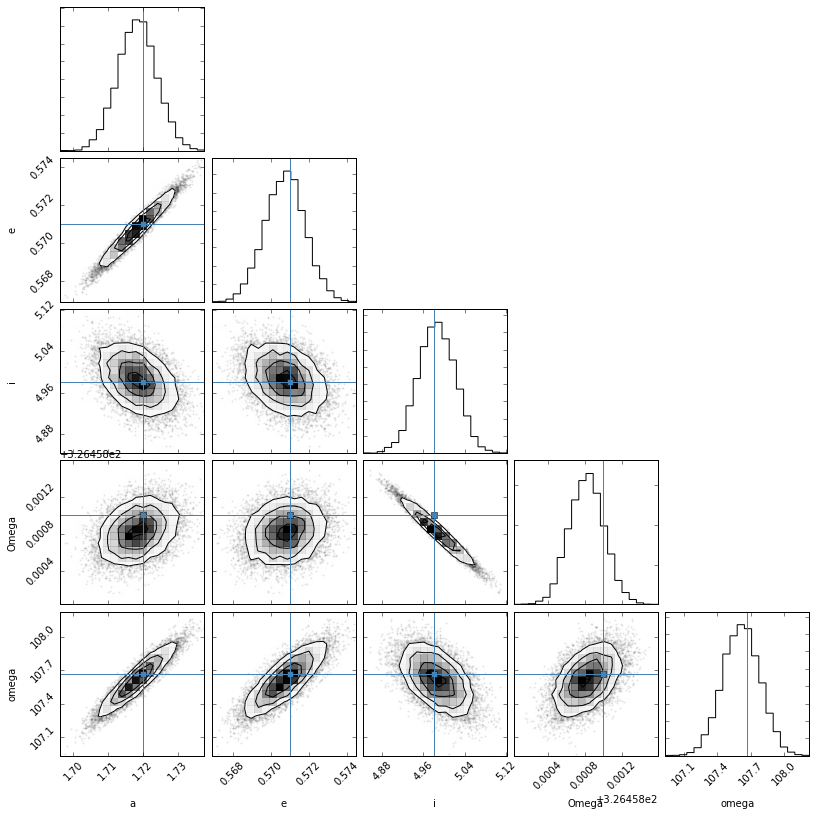

In [5]:
figure = corner.corner(samples, truths=[1.72,0.571,4.98,326.459,107.67],labels=["a","e","i","Omega","omega"])